<a href="https://colab.research.google.com/github/ElpoderdelComputo/Tutoriales_YouTube/blob/main/Validacion_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Validacion cruzada**
# ***El poder del Cómputo***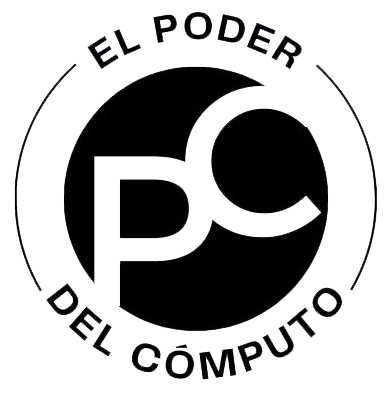

In [ ]:
# -*- coding: utf-8 -*-

# Importar las librerias a utilizar
import pandas as pd
# Abre archivo >>> Train_RF_2021.csv desde google drive
df= pd.read_csv("/content/drive/MyDrive/DATOS_2002_2021/Train_2021.csv", header=0)

#Mostrar primeros 5 registros
df[:5]

,X,Y,R,G,B,ExG,ExR,ExGR,CIVE,VEG,NGRDI,NDI,CLASE
0,26,89,62,76,76,14,10.8,3.2,28.95345,1.145453,0.101449,140.985507,4
1,24,88,66,80,81,13,12.4,0.6,30.39845,1.132214,0.095890,140.273973,4
2,26,87,67,81,81,14,12.8,1.2,30.02845,1.134926,0.094595,140.108108,4
3,27,87,67,82,79,18,11.8,6.2,28.04745,1.158543,0.100671,140.885906,4
4,80,61,70,71,73,-1,27.0,-28.0,34.78145,1.000211,0.007092,128.907801,4


In [ ]:
import numpy as np
# Valores de X: R,G,B,ExR,NGRDI
X = df.iloc[: , [2,3,4,5,10]].values
# y es la columna 12
y = df.iloc[: , 12].values

#imprime etiquetas de clases
print('Etiquetas de clase:', np.unique(y))
print(X[:5])

Etiquetas de clase: [1 2 3 4]
[[ 6.20000000e+01  7.60000000e+01  7.60000000e+01  1.40000000e+01
   1.01449275e-01]
 [ 6.60000000e+01  8.00000000e+01  8.10000000e+01  1.30000000e+01
   9.58904110e-02]
 [ 6.70000000e+01  8.10000000e+01  8.10000000e+01  1.40000000e+01
   9.45945950e-02]
 [ 6.70000000e+01  8.20000000e+01  7.90000000e+01  1.80000000e+01
   1.00671141e-01]
 [ 7.00000000e+01  7.10000000e+01  7.30000000e+01 -1.00000000e+00
   7.09219900e-03]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## División de datos en 90% de entrenamiento y 10% de datos de prueba:
# random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10,
                                                    stratify=y,
                                                    random_state=1)

In [ ]:
# Mostrar cuantos datos hay en total: en entrenamiento y prueba
print('\nNumero de etiquetas en y:', np.bincount(y))
print('Numero de etiquetas en y_train:', np.bincount(y_train))
print('Numero de etiquetas en y_test:', np.bincount(y_test))

# Estandarizar los datos
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


Numero de etiquetas en y: [   0 2672 2246 3507 1718]
Numero de etiquetas en y_train: [   0 2405 2021 3156 1546]
Numero de etiquetas en y_test: [  0 267 225 351 172]


In [ ]:
# una prueba rapida 
clf = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=50,
                       n_jobs=-1, random_state=1)

## Se entrena el modelo
clf.fit(X_train_std, y_train)
# score de entrenamiento 
pg2 = clf.score(X_train_std, y_train)

print('\nTrain Accuracy clf: %.5f' % pg2)

#Evaluando la prediccion con Xtest
y_pred = clf.predict(X_test_std)

print('Test Accuracy clf: %.5f' % clf.score(X_test_std, y_test))


Train Accuracy clf: 0.91630
Test Accuracy clf: 0.90345


In [ ]:
from sklearn.model_selection import GridSearchCV
# Búsqueda exhaustiva de hiperparámetros especificados para un estimador

# Número de árboles en el random forest (ne)
n_estimators = [50,100]

# El número de características a considerar al buscar la mejor división: (mc)
max_features = ['log2','sqrt']

#criterio de impureza (cr)
criterion = ['gini','entropy'] 

# Número máximo de niveles en el árbol (mp)
max_depth = [8,10,11]

# Crear retícula
param_grid = [{'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth}]


# Crear el modelo base para ajustar
rf = RandomForestClassifier()

# Validacion cruzada con k=10
#busqueda exhaustiva
gs = GridSearchCV(estimator = rf, 
                  param_grid = param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,              
                  n_jobs=-1)

# Sea justan los modelos
gs = gs.fit(X_train_std, y_train)

# Mejor score
print(gs.best_score_)
# Mejores parametros
print(gs.best_params_)

# El mejor estimador 
clf = gs.best_estimator_

0.9252881141792049
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


0.9246280664376059

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}

In [ ]:
# Evaluamos el mejor estumador con X_test_std y y_test
print('Test accuracy: %.5f' % clf.score(X_test_std, y_test))

Test accuracy: 0.92315


In [ ]:
# Validacion cruzada con k=10 del mejor modelo ajustado 
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate

# Metricas de evaluación con todos los datos 
scoring = {'prec_weighted': make_scorer(precision_score, average='macro'),
          'rec_weighted': make_scorer(recall_score, average='macro'),
          'f1_weighted': make_scorer(f1_score, average='macro'),
          'acc_weighted': make_scorer(accuracy_score)}

# Se utiliza mismo conjunto de datos
# División 90% de datos para entrenamiento, 10% de daatos para test
# random_state = 1 , k = 10
cvA = StratifiedShuffleSplit(n_splits=10, random_state=1)

# Se asignan las matrices de los datos de entrenamiento y prueba
crossVA = cvA.split(X_train_std, y_train)

# se inicia validacion
scores = cross_validate(estimator=clf,
                        X=X_train_std,y=y_train, 
                        scoring = scoring, 
                        return_estimator= True, 
                        cv = crossVA,
                        n_jobs=-1)

# Se imprimen los valores promedio y desviacion estandard de cada score
#print('CV scores: %s' % scores)
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores['test_acc_weighted']),np.std(scores['test_acc_weighted'])))
print('F1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1_weighted']),np.std(scores['test_f1_weighted'])))
print('Presicion: %.3f +/- %.3f' % (np.mean(scores['test_prec_weighted']),np.std(scores['test_prec_weighted'])))
print('Recall: %.3f +/- %.3f' % (np.mean(scores['test_rec_weighted']),np.std(scores['test_rec_weighted'])))
# se muestran los valores de cada score por cada particion
print("\n\t\tAccuracy\n")
print(scores['test_acc_weighted']) 
print("\n\t\t F1 \n")
print(scores['test_f1_weighted'])
print("\n\t\t Prec \n")
print(scores['test_prec_weighted'])
print("\n\t\t Rec \n")
print(scores['test_rec_weighted'])

Accuracy: 0.924 +/- 0.005
F1 score: 0.911 +/- 0.005
Presicion: 0.920 +/- 0.006
Recall: 0.907 +/- 0.005

		Accuracy

[0.92442497 0.92771084 0.932092   0.92990142 0.9211391  0.92223439
 0.91456736 0.92223439 0.92990142 0.92004381]

		 F1 

[0.90884847 0.91517457 0.91803534 0.91638927 0.90662655 0.90934293
 0.90184542 0.91069897 0.91749202 0.90747603]

		 Prec 

[0.92091233 0.92201133 0.92835816 0.92752597 0.91480255 0.91884409
 0.91171307 0.91519098 0.92512965 0.91260907]

		 Rec 

[0.90292508 0.91092507 0.91341129 0.91131132 0.90271185 0.9053435
 0.89762767 0.90773554 0.91345488 0.90443955]


In [ ]:
# Mostrar Metricas por cada particion
ACC = scores['test_acc_weighted']
F1 = scores['test_f1_weighted']
PREC = scores['test_prec_weighted']
REC = scores['test_rec_weighted']

print('CV, Part, acc,  F1,   prec,   Rec')
for i in range(10):
  print('CV:',i+1  , '%.5f' % ACC[i], '%.5f' % F1[i],'%.5f' %  PREC[i],'%.5f' % REC[i])

CV, Part, acc,  F1,   prec,   Rec
CV: 1 0.92442 0.90885 0.92091 0.90293
CV: 2 0.92771 0.91517 0.92201 0.91093
CV: 3 0.93209 0.91804 0.92836 0.91341
CV: 4 0.92990 0.91639 0.92753 0.91131
CV: 5 0.92114 0.90663 0.91480 0.90271
CV: 6 0.92223 0.90934 0.91884 0.90534
CV: 7 0.91457 0.90185 0.91171 0.89763
CV: 8 0.92223 0.91070 0.91519 0.90774
CV: 9 0.92990 0.91749 0.92513 0.91345
CV: 10 0.92004 0.90748 0.91261 0.90444


In [ ]:
# Guardando el mejor modelo
import joblib
joblib.dump(clf, "./RF_M_K10.pkl")

['./RF_M_K10.pkl']

In [ ]:
#importamos el mejor modelo ajustado 
clf_entrenado = joblib.load('/content/RF_M_K10.pkl')